# Final project for Supervised Learning class

For the final project I chose dataset from kaggle focusing on Fetal Health Classification (https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification), some of the aspects that made me choose this data to work on:
- it's a real world data, produced by medical equipment, this introduces noise to data and makes it more challenging,
- it's multiclass classification, in the classes we focused mostly on binary problems or toy cases, like MNIST,
- dataset is imbalanced (there's big difference in amount of samples for each class), which introduce additional complication and requires exploration of different methods to address it.

I want to address few aspects:
- how much will normalization impact results,
- which strategies work best for imbalanced dataset: oversamplig, class weights, threshold moving and regularization.

Models used for testing:
- Random Forest
- SVM
- KNNClassifier - used only for normalization tests
- AdaBoost

## Data exploration

From dataset description:

    Context

    Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress.
    The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

    Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

    In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.
    Data

    This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

    - Normal
    - Suspect
    - Pathological

In this section I'll conduct a standard EDA procedure to get familiar with the data.

In [80]:
from pathlib import Path

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from copy import copy

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

from visualizations import visualize_classes_pca, visualize_classes_tsne

In [2]:
# Fetch data
data_dir = Path('./data')
data_dir.mkdir(parents=True, exist_ok=True)
dataset = 'andrewmvd/fetal-health-classification'
csv_path = data_dir / 'fetal_health.csv'

if not csv_path.exists():
    api = KaggleApi()
    api.authenticate()
    
    api.dataset_download_files(
        dataset=dataset,
        path=str(data_dir),
        unzip=True,
    )

data = pd.read_csv(csv_path)
target_col = 'fetal_health'

In [3]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [5]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


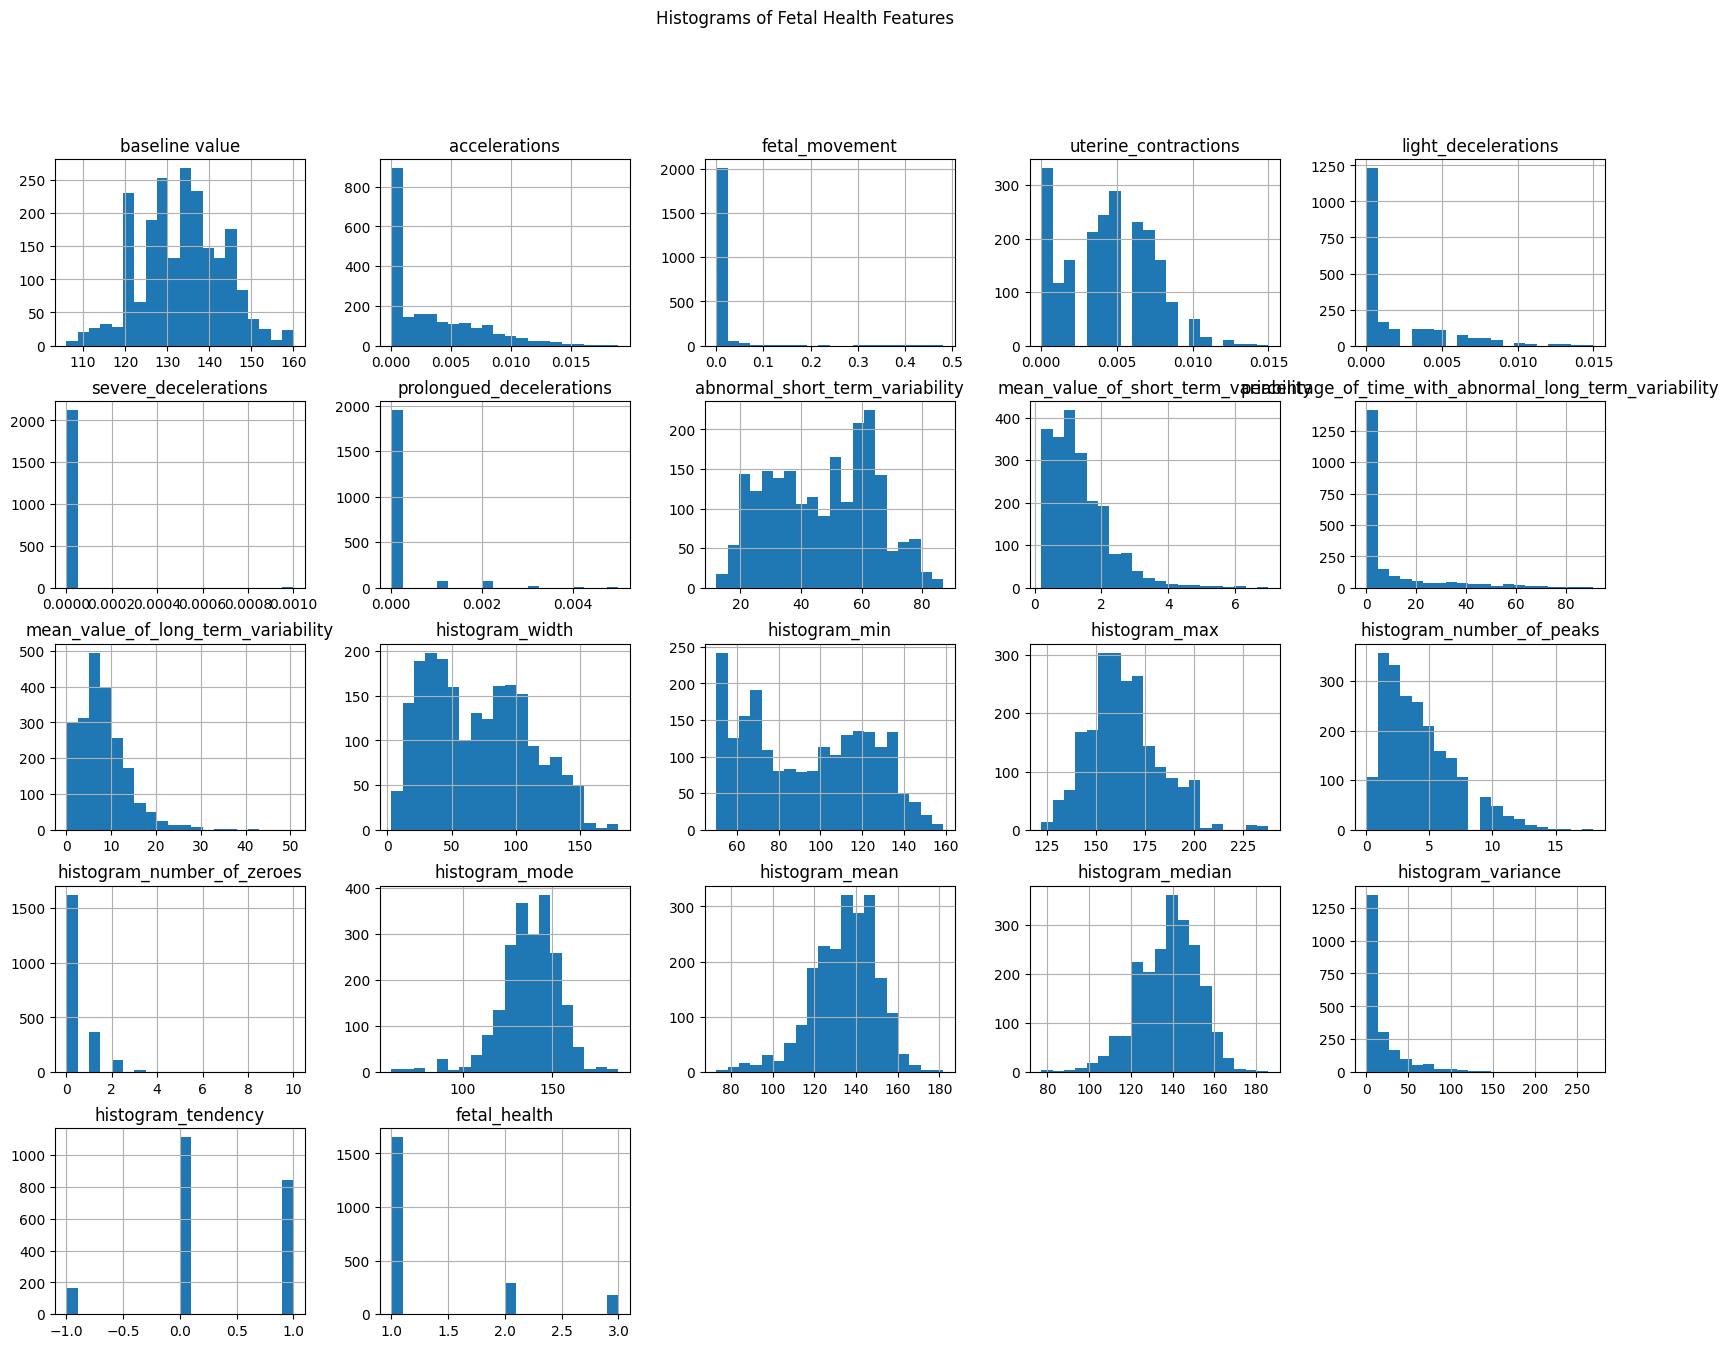

In [6]:
data.hist(bins=20, figsize=(20, 15))
plt.suptitle("Histograms of Fetal Health Features")

plt.show()

In [7]:
np.unique(data['histogram_tendency'])

array([-1.,  0.,  1.])

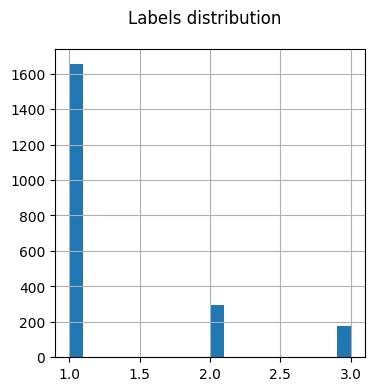

In [8]:
data['fetal_health'].hist(bins=20, figsize=(4, 4))
plt.suptitle("Labels distribution")

plt.show()

As we can see, all features are numerical and with varying ranges, which at first glance suggests that data normalization in this case will make a significant difference. Additionally based on observed values we can assume that `histogram_tendency` is representing a categorical but because of it's nature (values: -1, 0, 1), I'll leave it as is, without binarization.

## Features overview


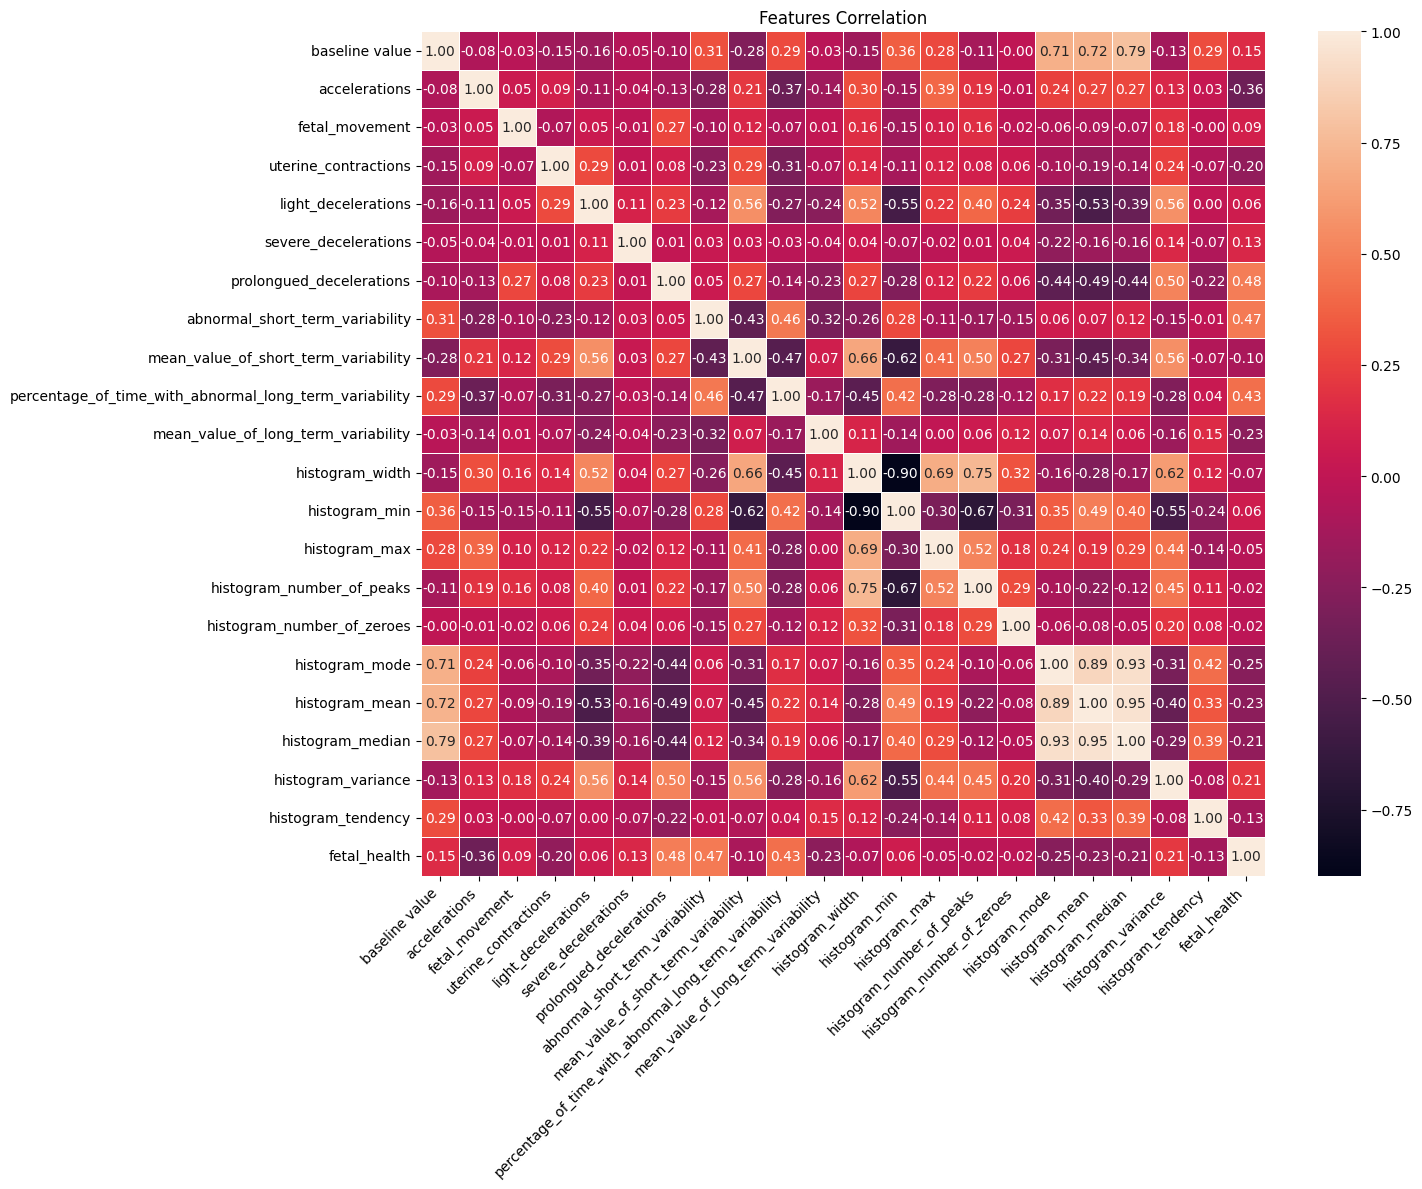

In [9]:
plt.figure(figsize=(15,12))  # adjust size
sns.heatmap(
    data.corr(), 
    annot=True,         
    fmt=".2f",          
    linewidths=0.5,
    cbar=True,
    square=True
)

plt.title("Features Correlation")
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)               
plt.tight_layout()
plt.show()

Based on correlation matrix, these features do not exhibit high correlation risk, except for two hot spot areas,
related mainly to histogram values. Taking into account fact that there are only 20 features it doesn't seem 
necessary to remove feaures at this moment.

## Some fun with visualizations

Out of curiosity I want to check if visually we can observe any patterns in data. To do that I'm using PCA an t-SNE to reduce dimentionality and visualize it in 2D. Based on obtained scatter plots there is a certain pattern, where abnormal classes `Suspect` and `Pathological` are on the most left right side, but there's still a lot of overlapping samples from class `Normal`. This however is just for curiosity sake and doesn't fully represent data complexity, since it was compressed only to two classes. However it shows logical results, where most extrame cases on both sides are abnormal.

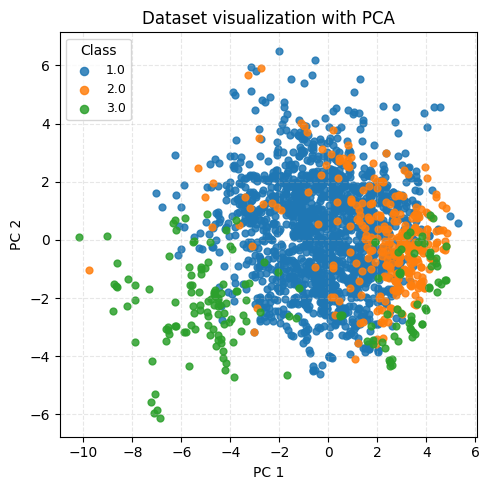

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Dataset visualization with PCA'}, xlabel='PC 1', ylabel='PC 2'>)

In [10]:
visualize_classes_pca(data, target_col)

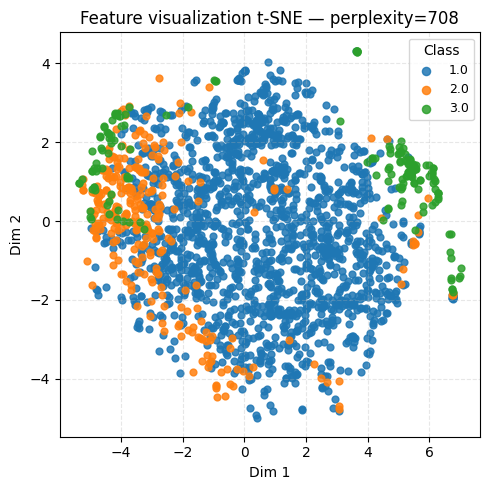

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Feature visualization t-SNE — perplexity=708'}, xlabel='Dim 1', ylabel='Dim 2'>)

In [11]:
visualize_classes_tsne(data, target_col)

## Data preprocessing

To ensure that, after split int train and test sets, obtained datasets both contain samples from each class I'm using `stratify` argument in `train_test_split` function.

In [16]:
X = data.drop(columns=[target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)



<Axes: >

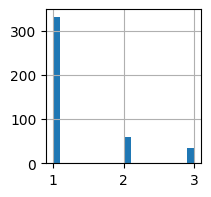

In [18]:
# quick sanity check 
y_test.hist(bins=20, figsize=(2, 2))

**Scaling vs normalizing**

Sklearn offers few ways to scale/normalize features an I want to try three of them in this notebook:
- StandardScaler
$ \frac{x_i - mean(x)}{stdev(x)} $

- MinMaxScaler
$ \frac{x_i - min(x)}{max(x) - min(x)} $
  
- Normalizer - scales each value by dividing by it's magnitude in n-dimensional space, formula for 3 dimensional space:
$ \frac{x_i}{\sqrt{x_{i}^2 + y_{i}^2} + z_{i}^2} $


They are described well, with visual examples in this post: https://benalexkeen.com/feature-scaling-with-scikit-learn/

In [21]:
s_scaler = preprocessing.StandardScaler().fit(X_train)
Xs_train = s_scaler.transform(X_train)
Xs_test = s_scaler.transform(X_test)

min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)
Xm_train = min_max_scaler.transform(X_train)
Xm_test = min_max_scaler.transform(X_test)

normalizer = preprocessing.Normalizer().fit(X_train)
Xnorm_train = normalizer.transform(X_train)
Xnorm_test = normalizer.transform(X_test)

## Normalization / scaling impact

First experiment is to compare impact of data scaling and normalization on results. It's important to remembet that for different types of data different funtions will generate better results, for example SampleScaler assumes that data is normally distributed, in our case it's not true for all features so this method can perform worse than other. In real life project it might be valuable to employ few different methods depending on characteristics of each feature.

To test which performs best I'm training a classifier representing each method on each data sample to evaluate impact and choose best method for this case. For classifiers I'm using default options, since we're not optimizing classifiers yet, only choosing data preprocessing method.

In [97]:
clfs = [
    ('SVC', svm.SVC(decision_function_shape="ovr")),  # one-vs-rest
    ('AdaBoost', AdaBoostClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('KNeighborsClassifier', KNeighborsClassifier())
]
data_sets = [
    ('baseline', X_train, X_test),
    ('Standard', Xs_train, Xs_test),
    ('MinMax', Xm_train, Xm_test),
    ('Norm', Xnorm_train, Xnorm_test)
]

results = {
    'index': [],
    'acc_train': [],
    'acc_test': [],
    'f1_train': [],
    'f1_test': []
}

for name, clf in clfs:
    for d_name, trainset, testset in data_sets:
        print('Fitting:', name, ', on data:', d_name)
        tmp_clf = copy(clf)
        tmp_clf.fit(trainset, y_train)
        pred_train = tmp_clf.predict(trainset)
        pred_test = tmp_clf.predict(testset)
        
        results['index'].append((name, d_name))
        results['acc_train'].append(accuracy_score(y_train, pred_train))
        results['acc_test'].append(accuracy_score(y_test, pred_test))
        results['f1_train'].append(f1_score(y_train, pred_train, average='weighted'))
        results['f1_test'].append(f1_score(y_test, pred_test, average='weighted'))

Fitting: SVC , on data: baseline
Fitting: SVC , on data: Standard
Fitting: SVC , on data: MinMax
Fitting: SVC , on data: Norm
Fitting: AdaBoost , on data: baseline
Fitting: AdaBoost , on data: Standard
Fitting: AdaBoost , on data: MinMax
Fitting: AdaBoost , on data: Norm
Fitting: RandomForest , on data: baseline
Fitting: RandomForest , on data: Standard
Fitting: RandomForest , on data: MinMax
Fitting: RandomForest , on data: Norm
Fitting: KNeighborsClassifier , on data: baseline
Fitting: KNeighborsClassifier , on data: Standard
Fitting: KNeighborsClassifier , on data: MinMax
Fitting: KNeighborsClassifier , on data: Norm


In [98]:
results_df = pd.DataFrame.from_dict(results)
results_df = results_df.set_index('index')
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=['Classifier', 'Method'])
results_df

acc_train  acc_test  f1_train   f1_test
Classifier           Method                                           
SVC                  baseline   0.860000  0.854460  0.848073  0.843669
                     Standard   0.935882  0.894366  0.934752  0.890065
                     MinMax     0.919412  0.887324  0.916827  0.881153
                     Norm       0.845882  0.833333  0.829705  0.814791
AdaBoost             baseline   0.917059  0.882629  0.915734  0.879333
                     Standard   0.917059  0.882629  0.915734  0.879333
                     MinMax     0.917059  0.882629  0.915734  0.879333
                     Norm       0.908824  0.873239  0.909608  0.873018
RandomForest         baseline   0.999412  0.929577  0.999411  0.928096
                     Standard   0.999412  0.927230  0.999411  0.924913
                     MinMax     0.999412  0.929577  0.999411  0.925965
                     Norm       0.999412  0.910798  0.999412  0.905704
KNeighborsClassifier baseline   0.932941  0.894366  0.931043  0.890119
                     Standard   0.938824  0.870892  0.937105  0.862905
                     MinMax     0.940588  0.880282  0.938484  0.871879
                     Norm       0.920000  0.866197  0.917294  0.861629

**Conclusion** of this part is that StandardScaler worked the best, it's impact is very different depending on the classifier. Nontheless, even in tree-based methods, which are mostly unbothered by data ormalization we can see that it makes difference in test scores, while most heavily affected SVC shows preference towards StandardScaler in all scores.
Based on this experiments we can theorize, that even when not all features have normal distribution, scaling can be halpful and benefits can be quite high. In next experiments I'll be using only scaled data.

## Addressing imbalanced data

There are few options to address imbalanced data during training, but not all of them are applicable to the clasisfier we're using, so in this notebook I'll focus on `class_weight`.
In this part of experimenting I'll focus on confusion matrix and precision, recall, f1 metrics, since they're the best to explore misclassifications between multiple classes.

Bacause of classifiers restrictions, I'll be able to compare two of them, which have implemented this feature:
- RandomForest
- SVC
  

In [81]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', normalize='true'):
    labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    
    values_format = ".2f"
    cmap="Blues"
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
    disp.plot(include_values=True, cmap=cmap, ax=ax, xticks_rotation=0, values_format=values_format, colorbar=True)
    ax.set_title(title or ("Confusion Matrix" + (f" (normalized: {normalize})" if normalize else "")))
    plt.tight_layout()
    return ax

def precision_recall_table(
    y_true,
    y_pred,
    averages=("macro",),          # any of: "macro", "micro", "weighted"
):
    labels = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))
    p, r, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    df = pd.DataFrame(
        {"precision": p, "recall": r, "f1": f1, "support": support},
        index=pd.Index(labels, name="class")
    )
    return df

In [89]:
svm_base = svm.SVC(decision_function_shape="ovr").fit(Xs_train, y_train)  # one-vs-rest
rf_base = RandomForestClassifier().fit(Xs_train, y_train)

SVM scores
        precision    recall        f1  support
class                                        
1.0     0.930636  0.969880  0.949853      332
2.0     0.666667  0.576271  0.618182       59
3.0     0.862069  0.714286  0.781250       35 

RandomForest scores
        precision    recall        f1  support
class                                        
1.0     0.942029  0.978916  0.960118      332
2.0     0.833333  0.677966  0.747664       59
3.0     0.909091  0.857143  0.882353       35 



<Axes: title={'center': 'RandomForest baseline Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

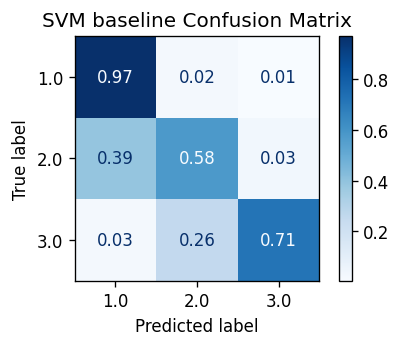

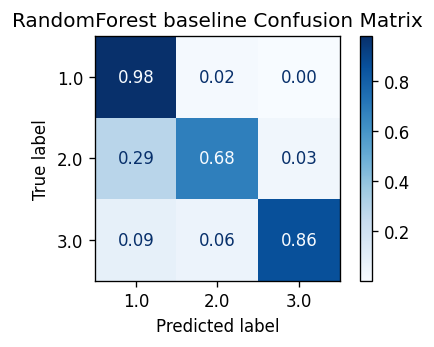

In [90]:
svm_pred = svm_base.predict(Xs_test)
rf_pred = rf_base.predict(Xs_test)

svm_scores = precision_recall_table(y_test, svm_pred)
print('SVM scores\n', svm_scores, '\n')

rf_scores = precision_recall_table(y_test, rf_pred)
print('RandomForest scores\n', rf_scores, '\n')

plot_confusion_matrix(y_test, svm_pred, 'SVM baseline Confusion Matrix')
plot_confusion_matrix(y_test, rf_pred, 'RandomForest baseline Confusion Matrix')

Taking the closer look on confusion matrix, it's clear how big of a problem is an imbalanced dataset and using general metrics, which in previous experiment looked really good for all classifiers.

Now, let's compare it with results when using balanced weights.

In [95]:
svm_bal = svm.SVC(decision_function_shape="ovr", class_weight='balanced').fit(Xs_train, y_train)  # one-vs-rest
rf_bal = RandomForestClassifier(class_weight='balanced_subsample').fit(Xs_train, y_train)

SVM scores
        precision    recall        f1  support
class                                        
1.0     0.989933  0.888554  0.936508      332
2.0     0.565217  0.881356  0.688742       59
3.0     0.777778  0.800000  0.788732       35 

RandomForest scores
        precision    recall        f1  support
class                                        
1.0     0.947674  0.981928  0.964497      332
2.0     0.875000  0.711864  0.785047       59
3.0     0.911765  0.885714  0.898551       35 



<Axes: title={'center': 'RandomForest baseline Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

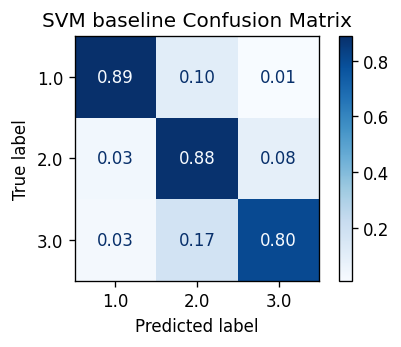

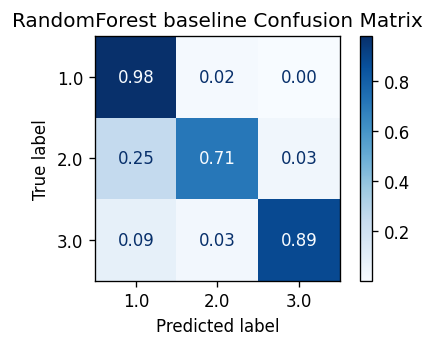

In [96]:
svm_bal_pred = svm_bal.predict(Xs_test)
rf_bal_pred = rf_bal.predict(Xs_test)

svm_bal_scores = precision_recall_table(y_test, svm_bal_pred)
print('SVM scores\n', svm_bal_scores, '\n')

rf_bal_scores = precision_recall_table(y_test, rf_bal_pred)
print('RandomForest scores\n', rf_bal_scores, '\n')

plot_confusion_matrix(y_test, svm_bal_pred, 'SVM baseline Confusion Matrix')
plot_confusion_matrix(y_test, rf_bal_pred, 'RandomForest baseline Confusion Matrix')

In [101]:
svm_acc = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

svm_bal_acc = accuracy_score(y_test, svm_bal_pred)
svm_bal_f1 = f1_score(y_test, svm_bal_pred, average='weighted')


rf_acc = accuracy_score(y_test, rf_bal_pred)
rf_f1 = f1_score(y_test, rf_bal_pred, average='weighted')

rf_bal_acc = accuracy_score(y_test, rf_pred)
rf_bal_f1 = f1_score(y_test, rf_pred, average='weighted')

print('SVM general metrics')
print(f'baseline, acc: {svm_acc}, f1: {svm_f1}')
print(f'balanced, acc: {svm_bal_acc}, f1: {svm_bal_f1}')

print('RandomForest general metrics')
print(f'baseline, acc: {rf_acc}, f1: {rf_f1}')
print(f'balanced, acc: {rf_bal_acc}, f1: {rf_bal_f1}')


SVM general metrics
baseline, acc: 0.8943661971830986, f1: 0.8900645768101052
balanced, acc: 0.8802816901408451, f1: 0.8900517143494268
RandomForest general metrics
baseline, acc: 0.9366197183098591, f1: 0.9342254697726382
balanced, acc: 0.9272300469483568, f1: 0.9243045407966011


## Conclusions

Even though per class f1 score improved, general metrics for classifiers went down. These experiments show how important is familiarity with different metrics and evaluation methods, and using them in the right context and how much of that depends on the data and our initial analysis. By taking extra care in the exploration phase we can either flag potential issues and be wary of them in the future or if situation requires it, adapt from the start and make necessary preparation before training the first model.